# Interictal Spikes Analysis

In [1]:
import os, re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

SPIKES_OUTPUT_DIR = "../../Data/spikes/devin_spikes/"
SEIZURES_DIR = "../../Data/seizures/source_mat/"
SEIZURE_BUFFER_TIME = 5  # hours

In [2]:
patient_hup_id = 210
fs = 1024

In [3]:
seizure_times_sec = np.load(os.path.join(SEIZURES_DIR, f"HUP_{patient_hup_id}.npy"))
seizure_times_samples = seizure_times_sec * fs
seizure_times_samples = seizure_times_samples.astype(int)
seizure_times_samples

array([[610603038, 610676613],
       [791951319, 792104919]])

In [4]:
# Initialize an empty list to hold the data
data = []

# Iterate through all files in the directory
for filename in os.listdir(SPIKES_OUTPUT_DIR):
    # Check if the file ends with .npy
    if filename.endswith(".npy"):
        # Use regular expression to match the pattern and extract desired numbers
        match = re.match(r"HUP(\d+)_phaseII_(\d+).npy", filename)

        if match:
            current_patient_hup_id = int(match.group(1))
            if current_patient_hup_id != patient_hup_id:
                continue
            interval_index = int(match.group(2))

            # Append the data to the list
            data.append(
                {
                    "filename": filename,
                    "interval_index": interval_index,
                }
            )

# Convert the list of dictionaries to a pandas DataFrame
spike_files_df = pd.DataFrame(data)
# Sort the DataFrame by the interval index
spike_files_df = spike_files_df.sort_values(by="interval_index")
# Reset the index
spike_files_df = spike_files_df.reset_index(drop=True)
# Add a new column called "start_sample_index"
spike_files_df["start_sample_index"] = spike_files_df["interval_index"] * fs * 60 * 2
spike_files_df

,filename,interval_index,start_sample_index
0,HUP210_phaseII_562.npy,562,69058560
1,HUP210_phaseII_576.npy,576,70778880
2,HUP210_phaseII_577.npy,577,70901760
3,HUP210_phaseII_586.npy,586,72007680
4,HUP210_phaseII_589.npy,589,72376320
...,...,...,...
7002,HUP210_phaseII_7766.npy,7766,954286080
7003,HUP210_phaseII_7767.npy,7767,954408960
7004,HUP210_phaseII_7768.npy,7768,954531840
7005,HUP210_phaseII_7769.npy,7769,954654720


In [5]:
# Initialize an empty list to store individual DataFrames
dfs = []

for index, row in spike_files_df.iterrows():
    filename = row["filename"]
    start_sample_index = row["start_sample_index"]

    # Load the data
    spike_data = np.load(os.path.join(SPIKES_OUTPUT_DIR, filename))

    # Convert all values to int
    spike_data = spike_data.astype(int)

    # Adjust the start_sample_index
    spike_data[:, 0] += start_sample_index

    # Convert the modified spike_data to a DataFrame and append to the dfs list
    dfs.append(
        pd.DataFrame(
            spike_data,
            columns=["peak_index", "channel_index", "sequence_index"],
        )
    )

# Concatenate all the individual DataFrames into a single DataFrame
all_spikes_df = pd.concat(dfs, ignore_index=True)

all_spikes_df

,peak_index,channel_index,sequence_index
0,69114386,40,0
1,69114427,0,0
2,69116031,40,1
3,69116031,39,1
4,70886208,0,0
...,...,...,...
650876,954776715,20,29
650877,954776717,21,29
650878,954776729,69,29
650879,954952677,0,0


In [6]:
# Calculate the buffer time in samples
buffer_samples = SEIZURE_BUFFER_TIME * 3600 * fs

In [7]:
# # Create a mask to determine which rows to keep
# mask = np.ones(len(all_spikes_df), dtype=bool)
# for start, end in seizure_times_samples:
#     mask &= ~(
#         (all_spikes_df["peak_index"] >= start - buffer_samples)
#         & (all_spikes_df["peak_index"] <= end + buffer_samples)
#     )

# # Use the mask to filter rows
# interictal_spikes_df = all_spikes_df.copy()[mask]

# # reset index
# interictal_spikes_df.reset_index(drop=True, inplace=True)

# interictal_spikes_df

## Raster plot

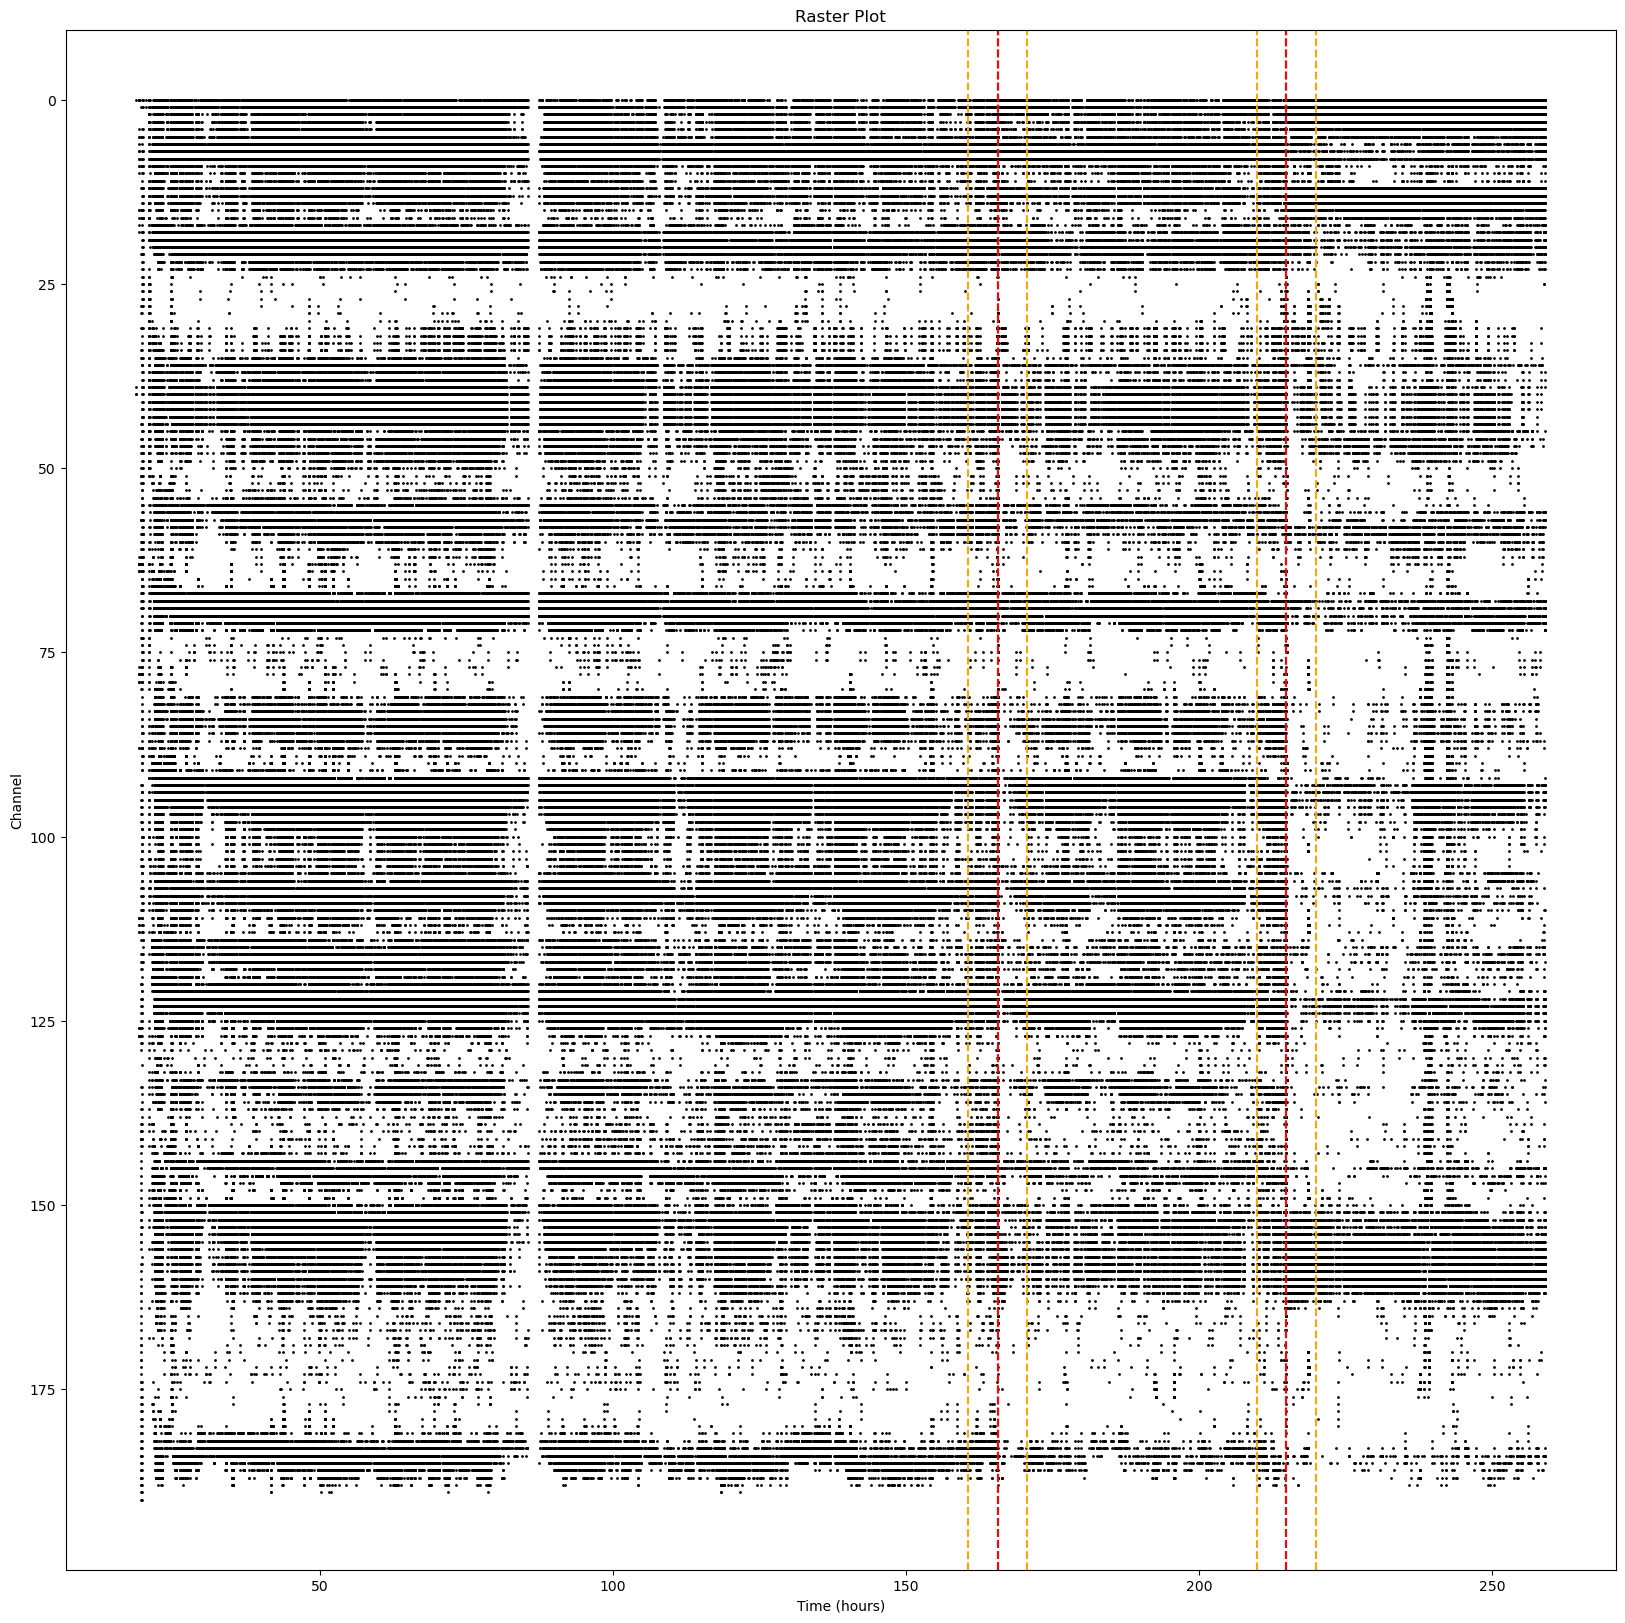

In [8]:
def raster_plot(df, seizure_times, buffer_samples, fs):
    fig, ax = plt.subplots(figsize=(20, 20))
    # Iterate through unique channels
    for channel in df["channel_index"].unique():
        # Extract spike times for this channel
        spike_times = df[df["channel_index"] == channel]["peak_index"]
        spike_times_in_hours = spike_times / (fs * 3600)  # Convert to hours
        ax.plot(spike_times_in_hours, [channel] * len(spike_times), "k.", markersize=2)

    # Plot vertical dashed lines for seizure times
    for start, end in seizure_times:
        ax.axvline(start / (fs * 3600), color="r", linestyle="--")
        ax.axvline(end / (fs * 3600), color="r", linestyle="--")

    # Plot vertical dashed lines for seizure times with buffer
    for start, end in seizure_times:
        ax.axvline(
            (start - buffer_samples) / (fs * 3600), color="orange", linestyle="--"
        )
        ax.axvline((end + buffer_samples) / (fs * 3600), color="orange", linestyle="--")

    ax.set_ylabel("Channel")
    ax.set_xlabel("Time (hours)")
    ax.set_title("Raster Plot")
    ax.invert_yaxis()  # Optional: to have channel 0 at the top
    plt.show()


raster_plot(all_spikes_df, seizure_times_samples, buffer_samples, fs)

## Inter-spike intervals

In [9]:
# Calculate the inter-spike interval
all_spikes_df["inter_spike_interval_samples"] = all_spikes_df["peak_index"].diff()

# If you want to handle the NaN value for the first row (since there's no previous spike to compare to):
all_spikes_df.loc[0, "inter_spike_interval_samples"] = 0  # or any other suitable value

# Convert the inter_spike_interval_samples column to integer
all_spikes_df["inter_spike_interval_samples"] = all_spikes_df[
    "inter_spike_interval_samples"
].astype(int)

all_spikes_df["inter_spike_interval_sec"] = (
    all_spikes_df["inter_spike_interval_samples"] / fs
).astype(int)

all_spikes_df.head(50)

# print the last 50 rows
all_spikes_df.tail(50)

,peak_index,channel_index,sequence_index,inter_spike_interval_samples,inter_spike_interval_sec
650831,954747101,94,15,3725,3
650832,954747106,69,15,5,0
650833,954747109,124,15,3,0
650834,954747125,7,15,16,0
650835,954747142,125,15,17,0
650836,954750171,94,16,3029,2
650837,954750191,71,16,20,0
650838,954760471,57,17,10280,10
650839,954760527,94,17,56,0
650840,954760677,20,18,150,0


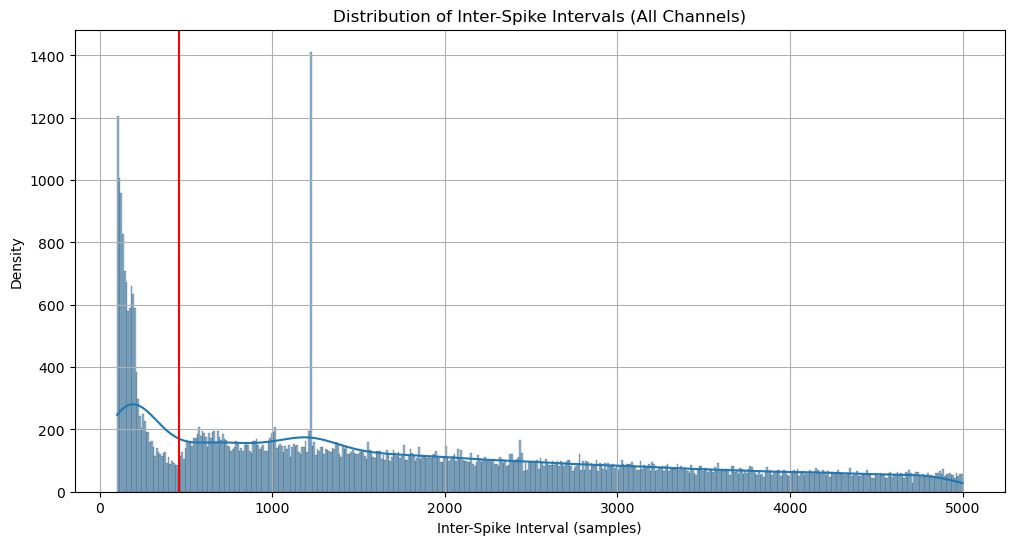

In [10]:
# Create a copy of all_spikes_df called all_spikes_df_copy_2

all_spikes_df_copy_2 = all_spikes_df.copy()

all_spikes_df_copy_2 = all_spikes_df_copy_2[
    all_spikes_df_copy_2["inter_spike_interval_samples"] > 100
]
all_spikes_df_copy_2 = all_spikes_df_copy_2[
    all_spikes_df_copy_2["inter_spike_interval_samples"] < 5000
]

plt.figure(figsize=(12, 6))
sns.histplot(all_spikes_df_copy_2["inter_spike_interval_samples"], kde=True, bins=500)
plt.title("Distribution of Inter-Spike Intervals (All Channels)")
plt.xlabel("Inter-Spike Interval (samples)")
plt.ylabel("Density")
# Plot a vertical red line at 500
plt.axvline(x=460, color="red")
plt.grid(True)
plt.show()

In [11]:
# Convert peak_index to hour
all_spikes_df["hour"] = all_spikes_df["peak_index"] // (fs * 3600)
all_spikes_df.head()

,peak_index,channel_index,sequence_index,inter_spike_interval_samples,inter_spike_interval_sec,hour
0,69114386,40,0,0,0,18
1,69114427,0,0,41,0,18
2,69116031,40,1,1604,1,18
3,69116031,39,1,0,0,18
4,70886208,0,0,1770177,1728,19


In [12]:
# Get the rows where hour is 20
all_spikes_df[all_spikes_df["hour"] == 20]

,peak_index,channel_index,sequence_index,inter_spike_interval_samples,inter_spike_interval_sec,hour
531,75064404,0,0,1699347,1659,20
532,75064404,1,0,0,0,20
533,76818566,45,0,1754162,1713,20
534,76818567,44,0,1,0,20
535,76818796,39,1,229,0,20
...,...,...,...,...,...,...
784,77267616,9,0,25,0,20
785,77267616,8,0,0,0,20
786,77267680,0,0,64,0,20
787,77267689,1,0,9,0,20


In [13]:
all_spikes_df["sequence_index_mask"] = (
    (all_spikes_df["sequence_index"].diff() != 0).astype(int).cumsum()
)
# Drop sequence_index column
all_spikes_df.drop(columns=["sequence_index"], inplace=True)

In [14]:
# Identify the first spike in each sequence
first_spikes = all_spikes_df.groupby("sequence_index_mask").first().reset_index()
print("Number of first spikes: ", len(first_spikes))
first_spikes.head(20)

Number of first spikes:  100873


,sequence_index_mask,peak_index,channel_index,inter_spike_interval_samples,inter_spike_interval_sec,hour
0,1,69114386,40,0,0,18
1,2,69116031,40,1604,1,18
2,3,70886208,0,1770177,1728,19
3,4,70893337,10,7115,6,19
4,5,70895057,7,1717,1,19
5,6,70936933,64,41874,40,19
6,7,70937553,0,614,0,19
7,8,70938270,0,693,0,19
8,9,70943257,77,4984,4,19
9,10,70965374,78,22116,21,19


In [15]:
# Filter out the first spikes
filtered_df = pd.concat([all_spikes_df, first_spikes]).drop_duplicates(keep=False)
assert len(filtered_df) == len(all_spikes_df) - len(first_spikes)
filtered_df.head(20)

,peak_index,channel_index,inter_spike_interval_samples,inter_spike_interval_sec,hour,sequence_index_mask
1,69114427,0,41,0,18,1
3,69116031,39,0,0,18,2
5,70886214,18,6,0,19,3
6,70886217,16,3,0,19,3
7,70886222,17,5,0,19,3
9,70893339,6,2,0,19,4
10,70893339,8,0,0,19,4
11,70893339,5,0,0,19,4
12,70893339,7,0,0,19,4
13,70893340,9,1,0,19,4


In [16]:
# Get the columns in filtered_df where hour is 20
filtered_df[filtered_df["hour"] == 20]

,peak_index,channel_index,inter_spike_interval_samples,inter_spike_interval_sec,hour,sequence_index_mask
532,75064404,1,0,0,20,37
533,76818566,45,1754162,1713,20,37
534,76818567,44,1,0,20,37
536,76818796,37,0,0,20,38
537,76818796,38,0,0,20,38
...,...,...,...,...,...,...
784,77267616,9,25,0,20,48
785,77267616,8,0,0,20,48
786,77267680,0,64,0,20,48
787,77267689,1,9,0,20,48


In [17]:
# Group by hour to calculate average inter_spike_interval_samples for the same spike train
avg_intervals = (
    filtered_df.groupby("hour")["inter_spike_interval_samples"].mean().reset_index()
)
avg_intervals.head(20)

,hour,inter_spike_interval_samples
0,18,20.500000
1,19,1.941176
2,20,7346.666667
3,21,220.087533
4,22,6.887662
5,23,7.177598
6,24,8.274478
7,25,7.382026
8,26,6.993516
9,27,6.126848


In [18]:
# Drop the rows in avg_intervalswhere inter_spike_interval_samples is above 100
avg_intervals = avg_intervals[avg_intervals["inter_spike_interval_samples"] < 10]
avg_intervals.head(20)

,hour,inter_spike_interval_samples
1,19,1.941176
4,22,6.887662
5,23,7.177598
6,24,8.274478
7,25,7.382026
8,26,6.993516
9,27,6.126848
10,28,7.471047
11,29,7.075728
12,30,8.290043


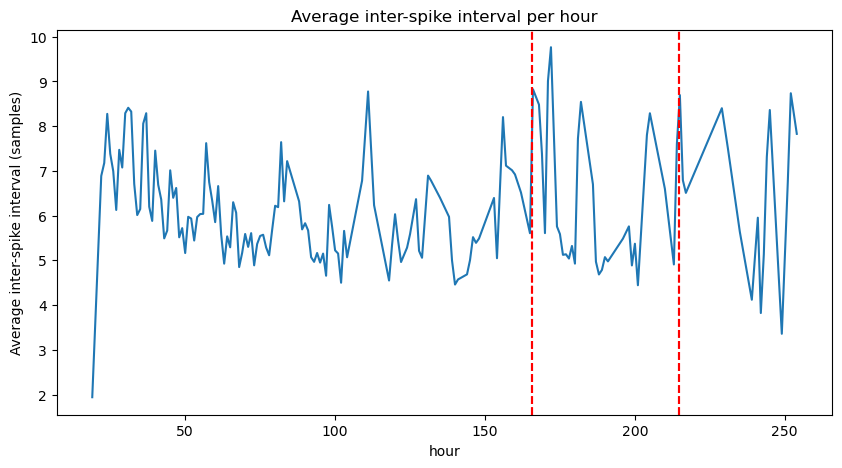

In [19]:
# Plot hour and inter_spike_interval_samples in avg_intervals
plt.plot(avg_intervals["hour"], avg_intervals["inter_spike_interval_samples"])

# Plot vertical lines indicating seizure times
for start, end in seizure_times_samples:
    plt.axvline(start / (fs * 3600), color="r", linestyle="--")
    plt.axvline(end / (fs * 3600), color="r", linestyle="--")

plt.xlabel("hour")
plt.ylabel("Average inter-spike interval (samples)")
plt.title("Average inter-spike interval per hour")

# Make the plot wider
plt.gcf().set_size_inches(10, 5)
plt.show()

## Spike Cascade Size Distribution